## 1D Burgers Equation - Physics Informed Neural Network

Equation:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, \quad x \in (-1, 1), \quad t > 0$$
$$ u(x, 0) = -\sin(\pi x) $$
$$ u(-1, t) = u(1, t) = 0 $$

In [1]:
from BurgersEquationClass import Burgers1D
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
key = jr.PRNGKey(39)

### Define the domain, initial condition, boundary condition and collocation points

Collocation points [Randomly sampled] = 1000 <- interior points for PINN training  <br>
Boundary points [Uniformly sampled] = 200 <- boundary points (100 for each boundary)  <br>
Initial condition points [Uniformly sampled] = 100

In [2]:
key, sampling_key1, sampling_key2 = jr.split(key, 3)

# Boundary points
x = jnp.linspace(-1, 1, 100)
t = jnp.linspace(0, 1, 50) 
BoundaryPoints = {'x': x, 't': t}

# Define the initial and boundary conditions   
ICFunction = lambda x: -jnp.sin(jnp.pi * x)
BCFunction = lambda t: 0
Conditions = {'IC': ICFunction, 'BC': BCFunction, 'BoundaryPoints': BoundaryPoints}

# Define the collocation points for PINN training
X = jr.uniform(sampling_key1, (1000,), minval=-1+0.001, maxval=1-0.001)
T = jr.uniform(sampling_key2, (1000,), minval=0+0.001, maxval=1)

Text(0, 0.5, 'x')

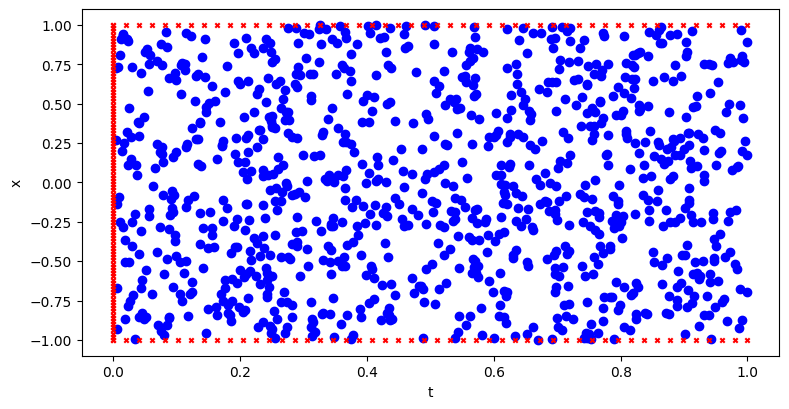

In [3]:
# Plot collocation points
fig, ax = plt.subplots(figsize=(9, 4.5))

# Scatter plot
ax.scatter(T, X, label='Collocation Points', color='blue')

# Plot initial and boundary conditions
ax.scatter(jnp.zeros_like(x), x, color='red', label='IC', marker='x', s=10)
ax.scatter(t, jnp.ones_like(t),color='red', label='BC', marker='x', s=10)
ax.scatter(t, -jnp.ones_like(t),color='red', label='BC', marker='x', s=10)

ax.set_xlabel('t')
ax.set_ylabel('x')
# ax.set_title('Scatter Plot of Collocation Points with IC and BC')
# ax.legend()

### Create the Burgers Equation model and define the loss function


In [4]:
key, init_key = jr.split(key)
burgers = Burgers1D(init_key, 10, 21, nu=0.01)

In [5]:
@eqx.filter_jit
def lossFunction(network, X, T, Conditions):
    # PDE loss
    pdeResidual = jax.vmap(network.PDE, in_axes=(0, 0))(X, T)
    pde_loss = jnp.mean(jnp.square(pdeResidual))

    # BC loss
    x = Conditions['BoundaryPoints']['x']
    t = Conditions['BoundaryPoints']['t']
    bc_loss_left = jnp.mean(jnp.square(jax.vmap(network, in_axes=(None, 0))(-1.0, t) - Conditions['BC'](t))) # Left BC
    bc_loss_right = jnp.mean(jnp.square(jax.vmap(network, in_axes=(None, 0))(1.0, t) - Conditions['BC'](t))) # Right BC    
    bc_loss = 0.5*bc_loss_left + 0.5*bc_loss_right

    # IC loss
    ic_loss = jnp.mean(jnp.square(jax.vmap(network, in_axes=(0, None))(x, 0.0) - Conditions['IC'](x))) # Initial Condition
    print(f'pde_loss: {pde_loss}, bc_loss: {bc_loss}, ic_loss: {ic_loss}')
    return pde_loss + 10*bc_loss + 20*ic_loss
    # return  ic_loss

lossFunction(burgers, X, T, Conditions)
loss_history = []

pde_loss: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, bc_loss: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>, ic_loss: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>


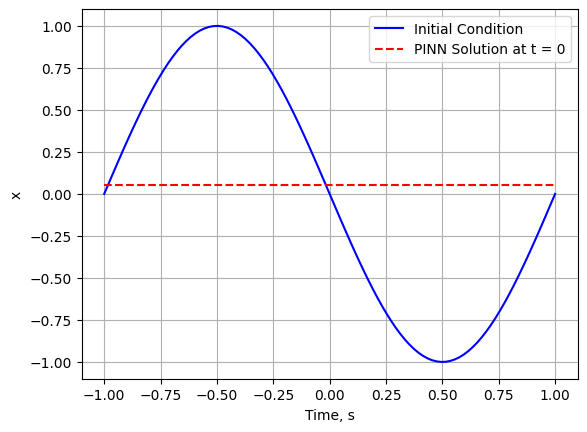

In [6]:
# Show the mismatch in IC 
plt.plot(x, Conditions['IC'](x), label="Initial Condition", color="blue")
plt.plot(x, jax.vmap(burgers, in_axes=(0, None))(x, 0.0), linestyle="--" ,label="PINN Solution at t = 0", color="red")
plt.xlabel("Time, s")
plt.ylabel("x")
plt.legend()
plt.grid()

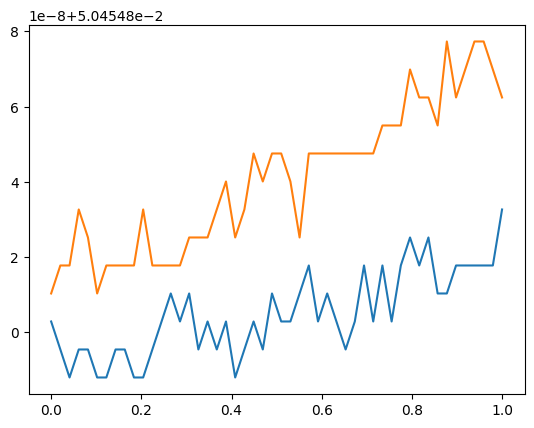

In [7]:
# Show the mismatch in BC
plt.plot(t, jax.vmap(burgers, in_axes=(None, 0))(1, t))
plt.plot(t, jax.vmap(burgers, in_axes=(None, 0))(-1, t))
plt.show()

In [ ]:
# Training PINN
LEARNING_RATE = 1e-4
N_OPTIMIZATION_EPOCHS = 30000

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(eqx.filter(burgers, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(lossFunction)(network, X, T, Conditions)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

for epoch in range(N_OPTIMIZATION_EPOCHS):
    burgers, opt_state, loss = make_step(burgers, opt_state)
    loss_history.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

In [ ]:
plt.plot(loss_history)
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
burgers(0.0, 0.0)

In [ ]:
plt.plot(x, Conditions['IC'](x))
plt.plot(x, jax.vmap(burgers, in_axes=(0, None))(x, 0.5))
plt.show()

Text(0, 0.5, 'x')

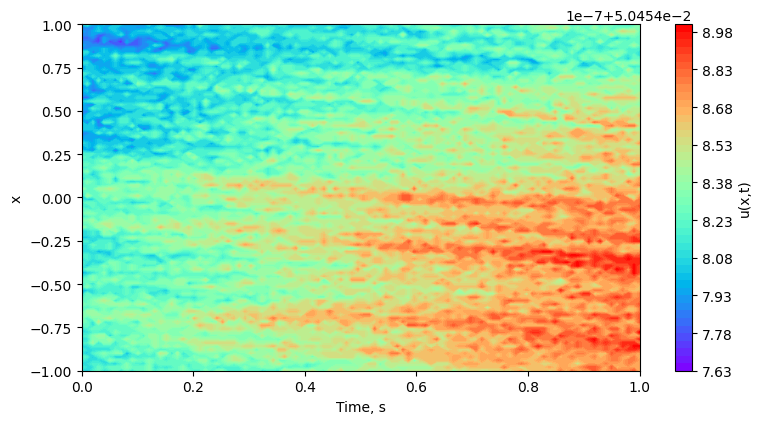

In [10]:
# Plot Burgers Equation Solution
xarr = jnp.linspace(-1, 1, 100)
tarr = jnp.linspace(0, 1, 100) 
Xmat, Tmat = jnp.meshgrid(xarr, tarr)
Umat = jnp.zeros((len(xarr), len(tarr)))  # Initialize U with the correct shape
for i in range(len(xarr)):
    Umat = Umat.at[i, :].set(jax.vmap(burgers, in_axes=(0, 0))(Xmat[i, :], Tmat[i, :]))

# Plot the contour
fig, ax = plt.subplots(figsize=(9, 4.5))

# Contour plot
contour = ax.contourf(Tmat, Xmat, Umat, levels=50, cmap='rainbow')
fig.colorbar(contour, ax=ax, label='u(x,t)')
ax.set_xlabel("Time, s")
ax.set_ylabel('x')
# ax.set_title('Contour Plot of Burgers Equation Solution')

In [ ]:
# Save the equinox model
eqx.tree_serialise_leaves("burgersNN.eqx", burgers.NN)

In [ ]:
# Save the model parameters
params = eqx.filter(burgers, eqx.is_array)  # Get the model parameters
jax.numpy.save('burgers_model_params.npy', params)  # Save parameters to a .npy file

In [ ]:
burgers1 = Burgers1D(init_key, layers=10, depth=20, nu=0.01)
loadedBurgers = eqx.tree_deserialise_leaves("burgersNN.eqx", burgers1.NN)
print(loadedBurgers(jnp.array(0.0, 0.5)))